In [1]:
## 20180421: update
## 11/19/15: change LGD calcs
## 11/16/15: alter to work with new worst345best959697 file
## 11/6/15: optimal cutoff about 4%.... so run worst4% cohort (works best)
## 11/2/15: added selector for worst% value (wpc)
## fixed incorrect parm table for final exhibits... do not use earlier versions!! worst5_Lags_norates best so far
## 11/1/15: added OREOgl and eOREO to PD, LGD calcs for grpTotUS

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
# Date selection for desired CCAR year:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

ccar = 2015

wpc = 4  # worst % threshold
grp = 'grpf4_2w'+str(wpc)  ## group to analyze within data file
grpf = 'f4'    ## target fail flag to analyze
grpm = 'f4_2'  ## target model to run

dtst = pd.to_datetime('2001-03-31')  # data start date for all CCAR years

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

dtend, frend

(Timestamp('2014-09-30 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [3]:
test = '_LossRates'  # 
cbo = ['NoLags','Lags','Lags_sUE2','Lags_sUE23'] # combo tags (for use in charts)
xvrn = [['UE2','sUE2','sUE3','UE_4','HPI_4','CRE_4'],['UE2','sUE2','sUE3'],['UE2','sUE3'],['UE2']]
frsq = [0,0,0] # set up list of full model adj r-sq values

## combo number: pick one:
#cbon = 0 # NoLags
cbon = 1 # Lags
#cbon = 2 # Lags_sUE2
#cbon = 3 # Lags_sUE23

############################################################################################################
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvri = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from st-var regressions
#xvri = []  ## USE THIS if you want to include int rate variables in regressions
############################################################################################################

styp = cbo[cbon]
if len(xvri)>0: styp = styp + "_NoRates"
xvr = list(set(xvrn[cbon] + xvri))
grp, styp, test

('grpf4_2w4', 'Lags_NoRates', '_LossRates')

In [4]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("df2_3z_grpTotUSx00.csv", index_col=0)
df.rename(columns = {'AsOf' : 'Date'}, inplace= True)

prm4 = pd.read_csv("modelrerun_f246_params_roe0mm2_2009.csv",index_col=0)

rclst = list(set(e for r in prm4[['v1','v2','v3','v4']].values for e in r))
rclst = [grpf,grpm,'lgdTotLn']+rclst

d2name = grpm + '_vars_worst345best959697.csv'
d2ww = pd.read_csv(d2name,header=[0,1],index_col=0)

d2w=d2ww.swaplevel(0,1,axis=1)
d2w.sort_index(axis=1,inplace=True)
d2w.index = pd.to_datetime(d2w.index)

d2wd = d2w[str(wpc)]

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])

hs = hs[hs['Date']>=dtst]

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE:
hs['UE2'] = hs['UE'] * hs['UE']

d2name

'f4_2_vars_worst345best959697.csv'

In [5]:
d2ww[[grpf, grpm]].head(2)

f4                                                    \
                   3         4         5        95        96        97   
AsOf                                                                     
2001-12-31  0.015686  0.011765  0.009412  0.000372  0.000368  0.000364   
2002-03-31  0.011858  0.008902  0.007126  0.000250  0.000247  0.000245   

                f4_2                                                    
                   3         4         5        95        96        97  
AsOf                                                                    
2001-12-31  0.029910  0.023346  0.019307  0.000648  0.000674  0.000705  
2002-03-31  0.024962  0.019624  0.016326  0.000631  0.000656  0.000686

In [6]:
## process sUE adjustments:

In [7]:
uex = hs[['Date','UE']].ix[hs['UE'].idxmax()]
uex['qtrs']=(uex['Date'].year-2000)*4 + uex['Date'].month/3
uec = cc[cc['CCAR']==ccar][['Date','UE']].ix[cc[cc['CCAR']==ccar]['UE'].idxmax()]
uec['qtrs']=(uec['Date'].year-2000)*4 + uec['Date'].month/3
uex, uec

(Date    2009-12-31 00:00:00
 UE                      9.9
 qtrs                     40
 Name: 135, dtype: object, Date    2016-06-30 00:00:00
 UE                     10.1
 qtrs                     66
 Name: 147, dtype: object)

In [8]:
dtlst = list(hs['Date'])+list(cc['Date'])
dtlst= sorted(list(set(dtlst)))
adj = pd.DataFrame(dtlst)
adj.columns=['Date']
adj['adj'+str(ccar-2000)] = 1.
#adj.head()

In [9]:
adjn = 'adj' + str(ccar-2000)
cadj = 1.0
adj[adjn] = 1.0
iadj = (1-uex['UE']/uec['UE'])/(uec['qtrs']-uex['qtrs'])
for i in np.arange(len(adj)):
  if adj.ix[i,'Date'] <= uex['Date']:
    adj.ix[i,adjn] = 1.0
  elif adj.ix[i,'Date'] >= uec['Date']:
    adj.ix[i,adjn] = uex['UE']/uec['UE']
  else:
    cadj = cadj - iadj
    adj.ix[i,adjn] = cadj

In [10]:
df.head(2)

Date          Grp  IDRSSD   nbr         Cert       eTotAst  \
0 2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
1 2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   

         eTotLn       eALLL      eOREO         eGW    ...         eTotrb  \
0  4.019129e+09  66654030.0  3654979.0  62574356.0    ...      12.424229   
1  4.052104e+09  67717331.0  3794355.0  65356631.0    ...      12.556711   

   eALLL_Ln      mxCx    mxSfFst      mxCRE       mxCI    mxCard      mxDDA  \
0  1.658420  4.526967  19.886307  12.274656  24.493310  5.417228  19.002339   
1  1.671165  4.757107  19.959003  12.389330  23.792958  5.606277  19.502725   

     eRWA_TA   lnTotAst  
0  77.388279  22.613255  
1  77.331733  22.621017  

[2 rows x 322 columns]

In [11]:
df[['Grp','Date']].groupby(['Grp']).count()

Date
Grp              
grpC18x00      70
grpC31x00      70
grpTotUSx00    70
grpTotUSx18    70
grpTotUSx31    70

In [12]:
df.columns[df.columns.str.contains('OREO')]

Index([u'eOREO', u'isOREOgl', u'qOREOgl'], dtype='object')

In [13]:
##  
##  CORRECTED defTotLn & lgdTotLn calculations for OREO components!!! (11/19/15)
##

## set up processing tables for calcs:
dfg3 = df[df['Grp']=='grpTotUSx00']  # set up for calc processing using old table names
dfg3a = dfg3.copy()  # table used to run calcs
dfg3a.set_index('Date',drop=True,inplace=True)

dfg3a['defTotLn'] = dfg3a.apply(lambda x: 100*(x['nTotLn'] + x['qncCard'] + x['qncOthCsmr']+x['eOREO'])/\
                                (x['eTotLn']+x['eOREO']),axis=1)
dfg3a['lgdTotLn'] = dfg3a.apply(lambda x: 400*(x['qncTotLn']-x['qOREOgl'])/\
                                (x['nTotLn'] + x['qncCard'] + x['qncOthCsmr']+x['eOREO']),axis=1)
dfg3a['def_lgd'] = dfg3a['defTotLn'] * dfg3a['lgdTotLn']/100
dfg3a['qOREOexp'] = dfg3a['qOREOgl']
dfg3a['eOREO'] = dfg3a['eOREO']

In [14]:
dfg3a[['defTotLn','lgdTotLn','def_lgd','rcTotLn','qcTotLn','eOREO','isOREOgl','qOREOgl','qncTotLn']].ix['2011']

defTotLn   lgdTotLn   def_lgd   rcTotLn   qcTotLn       eOREO  \
Date                                                                        
2011-03-31  3.809073  50.439553  1.921279  2.335388  1.881111  47918829.0   
2011-06-30  3.494698  46.923640  1.639840  2.052640  1.598765  47018268.0   
2011-09-30  3.318794  44.534731  1.478016  1.810239  1.426513  46367525.0   
2011-12-31  3.073886  47.795440  1.469178  1.570727  1.385262  42619064.0   

             isOREOgl    qOREOgl    qncTotLn  
Date                                          
2011-03-31  -902237.0  -902237.0  31473298.0  
2011-06-30 -1789320.0  -887083.0  27025383.0  
2011-09-30 -2834645.0 -1045325.0  24207546.0  
2011-12-31 -4448001.0 -1613356.0  24049011.0

In [15]:
if 'lgdTotLn' not in list(d2wd.columns):  ## prevents re-runs from changing col names to lgdTotLn_x, _y, etc.
  d2wd = d2wd.merge(dfg3a[['lgdTotLn','defTotLn','def_lgd']],how='left',left_index=True,right_index=True)

d2wd.tail(2)

aFF_TA  eALLL_Ln  eBrok_Dep    eLn_Dep      eT1rb     eTotrb  \
AsOf                                                                         
2018-03-31  5.059335  1.326633  17.457466  92.958300  10.296977  11.438691   
2018-06-30  4.691503  1.258997  16.021833  94.016775  10.295000  11.407004   

             f4      f4_2   lnTotAst   qnTotLn         rEff      rNIM  \
AsOf                                                                    
2018-03-31  0.0  0.011980  13.054040  1.590325  4851.696939  3.929004   
2018-06-30  0.0  0.010287  13.080623  1.477557  4686.098654  4.007257   

               rPPNR      rROA      rROE   rcTotLn   lgdTotLn  defTotLn  \
AsOf                                                                      
2018-03-31  1.011457  0.298054  1.051391  0.395153  58.686383  0.841580   
2018-06-30  1.103165  0.411316  2.560230  0.397904  59.492120  0.796598   

             def_lgd  
AsOf                  
2018-03-31  0.493893  
2018-06-30  0.473913

In [16]:
d2wd.columns

Index([u'aFF_TA', u'eALLL_Ln', u'eBrok_Dep', u'eLn_Dep', u'eT1rb', u'eTotrb',
       u'f4', u'f4_2', u'lnTotAst', u'qnTotLn', u'rEff', u'rNIM', u'rPPNR',
       u'rROA', u'rROE', u'rcTotLn', u'lgdTotLn', u'defTotLn', u'def_lgd'],
      dtype='object')

In [17]:
curlst = rclst

uvr = "adj" + str(ccar-2000)  ## colname for UE adj factors

dfc = df[df['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='all', inplace=True)

## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc[(cc['CCAR'] == ccar)]  # ccx contains forecast periods
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)

## CCAR vars: create lag (4q) terms for UE, HPI, CRE:
ccx[['UE_4','HPI_4','CRE_4']] = ccx[['UE','HPI','CRE']].shift(4)
if ccar <= 2015:
  ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE']].values
ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE']].values
ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE']].values
ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE']].values
if ccar >= 2016:
  ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-1)+'-09-30',['UE','HPI','CRE']].values

## CCAR vars: squared terms for UE and UE_4:
ccx['UE2'] = ccx['UE'] * ccx['UE']

ccx.sort_index(by=['Scen','Date'], inplace=True)
ccx = ccx.merge(adj[['Date',uvr]],how='left',on='Date')
ccx[uvr].fillna(1, inplace=True)
ccx.sort_index(by=['Scen','Date'], inplace=True)
ccx['sUE2'] = ccx['UE2'] * ccx[uvr] * ccx[uvr]
ccx['sUE3'] = ccx['sUE2'] * ccx['UE'] * ccx[uvr]
ccx.drop(uvr, axis=1, inplace=True)
ccx.sort_index(by=['Scen','Date'], inplace=True)

cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
cccol = [k for k in cccol if k not in xvr]   ## removes vars listed in xvr list

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsf = hs.copy()

## sUE2 variable = UE2*adj*adj:
hsf = hsf.merge(adj[['Date',uvr]],how='left',on='Date')
hsf[uvr].fillna(1, inplace=True)
hsf['sUE2'] = hsf['UE2'] * hsf[uvr] * hsf[uvr]
hsf['sUE3'] = hsf['sUE2'] * hsf['UE'] * hsf[uvr]
hsf.drop(uvr, axis=1, inplace=True)
hsf = hsf.merge(d2wd,how='inner',left_on='Date',right_index=True) # merge fail rates into history file (hs)
hsx = hsf[(hsf['Date'] >= dtst) & (hsf['Date'] <= dtend)] # historic periods

ccs = ccx.copy()  # CCAR scenarios for selected year
ccs['Intercept'] = 1  # to set up fitting model

hsf['Intercept'] = 1   # to set up fitting for all available history
hsz = hsf[(hsf['Date'] >= dtst)] # historic periods until current date


In [18]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsx, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm['rsq_adj'] = res_tot.rsquared_adj
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='outer', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='outer', left_index=True, right_index=True)

#frsq[cbon] = str(round(prm['rsq_adj']*100,1))

In [19]:
prm3.tail()

f4      f4_2  lgdTotLn  lnTotAst      rROE      rROA     eT1rb  \
UE_4    -0.020546 -0.008275 -3.869536 -0.060660 -0.533454  0.133886 -0.033238   
HPI_4    0.002448  0.004457  0.577644  0.004581 -0.753288 -0.034796 -0.025220   
CRE_4    0.001121  0.000215 -0.073079  0.004009 -0.010136 -0.008707 -0.005770   
rsq      0.972721  0.970702  0.846624  0.666569  0.988587  0.989771  0.897002   
rsq_adj  0.963137  0.960408  0.792735  0.549417  0.984576  0.986177  0.860813   

          qnTotLn  eBrok_Dep  
UE_4     0.799854  -0.972402  
HPI_4    0.044619   0.180575  
CRE_4    0.038769   0.063508  
rsq      0.987347   0.979893  
rsq_adj  0.982901   0.972828

In [20]:
grp + "_" + str(ccar) + "_full_9fcst_" + styp + test + ".csv"

'grpf4_2w4_2015_full_9fcst_Lags_NoRates_LossRates.csv'

In [21]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_9fcst_" + styp + test + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_9param_" + styp + test + ".csv")
ccar

2015

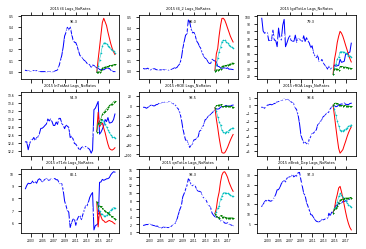

In [22]:
rlst = prm3.ix['rsq_adj'].values
xax = list(frt3.index)
plt.rcParams.update({'font.size': 3})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.title(str(ccar)+" "+curlst[i]+" "+styp)
  plt.annotate(str(round(rlst[i]*100,1)), xy=(0.5, 0.9),\
               xycoords='axes fraction', fontsize=3.5) # var listing annotation

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" +'_full9n_'+styp+test+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [23]:
grp+'_'+str(ccar) +'_full9n_'+styp+test+'.png'

'grpf4_2w4_2015_full9n_Lags_NoRates_LossRates.png'

In [24]:
### build 3-var models:

In [25]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsx, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsx, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [26]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsx, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [27]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3a.index.names = ['rci','v1i','v2i','i']
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [28]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsx, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [29]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4a.index.names = ['rci','v1i','v2i','v3i','i']
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [30]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsx, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt4 = frt.copy()

  frt4.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt4.copy()
  else:
    frt4b = frt4b.merge(frt4, how='outer', left_index=True, right_index=True)

In [31]:
df4bc = df4b.copy()
df4bc.reset_index(drop=True, inplace=True)
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
df4bc['ord'] = df4bc.apply(lambda x: dlst[x['rc2']], axis=1)
df4bc['rk'] = df4bc.index % topn+1
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9_"+styp
df4bc.tail(9)

rc2     v1        r1     v2        r2     v3        r3     v4  \
18      eT1rb     UE  0.715821     DJ  0.836593    VIX  0.855263    CRE   
19      eT1rb     UE  0.715821     DJ  0.836593    VIX  0.855263   rDIg   
20      eT1rb     UE  0.715821     DJ  0.836593  CRE_4  0.838885   rDIg   
21    qnTotLn     UE  0.893446  HPI_4  0.963844    HPI  0.972377   UE_4   
22    qnTotLn     UE  0.893446  HPI_4  0.963844    HPI  0.972377    CRE   
23    qnTotLn     UE  0.893446  CRE_4  0.963321   UE_4  0.971208     DJ   
24  eBrok_Dep   UE_4  0.742883  HPI_4  0.904664     DJ  0.947825    HPI   
25  eBrok_Dep   UE_4  0.742883  HPI_4  0.904664     DJ  0.947825    VIX   
26  eBrok_Dep  HPI_4  0.557156     DJ  0.803964     UE  0.941586  CRE_4   

          r4        Int        c1        c2        c3        c4          rc  \
18  0.860073  15.015910 -0.596736 -0.256091 -0.028144  0.006389      eT1rb0   
19  0.859119  15.847047 -0.659696 -0.204458 -0.021851 -0.026535      eT1rb1   
20  0.843721  15.615259 -0.714739 -0.153815 -0.003488 -0.030255      eT1rb2   
21  0.978338 -14.996427  2.071715  0.086744 -0.055172  0.330668    qnTotLn0   
22  0.977897 -16.124977  2.407346  0.048557 -0.037537  0.021592    qnTotLn1   
23  0.977424 -17.456403  1.562362  0.053476  0.815418 -0.195618    qnTotLn2   
24  0.968171   3.373606 -2.022651  0.164379 -0.919329  0.098697  eBrok_Dep0   
25  0.964098  12.787577 -2.094620  0.231772 -1.003792 -0.102816  eBrok_Dep1   
26  0.951645  13.876901  0.187106 -1.330533 -2.435593  0.052340  eBrok_Dep2   

    ord  rk                             Desc  
18    6   1  grpf4_2w4_2015_4v9_Lags_NoRates  
19    6   2  grpf4_2w4_2015_4v9_Lags_NoRates  
20    6   3  grpf4_2w4_2015_4v9_Lags_NoRates  
21    7   1  grpf4_2w4_2015_4v9_Lags_NoRates  
22    7   2  grpf4_2w4_2015_4v9_Lags_NoRates  
23    7   3  grpf4_2w4_2015_4v9_Lags_NoRates  
24    8   1  grpf4_2w4_2015_4v9_Lags_NoRates  
25    8   2  grpf4_2w4_2015_4v9_Lags_NoRates  
26    8   3  grpf4_2w4_2015_4v9_Lags_NoRates

In [32]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + styp + test + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + styp + test + '.csv')
ccar

2015

In [33]:
df4lst = []
for i in np.arange(len(df4bc)):
  ds = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ', ' +\
       df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst = df4lst + [ds]

df4bc['Annot'] = df4lst
df4bc[0:2]

rc2  v1        r1    v2       r2     v3        r3     v4        r4  \
0  f4  UE  0.649689  UE_4  0.84885  HPI_4  0.952326    VIX  0.957214   
1  f4  UE  0.649689  UE_4  0.84885  HPI_4  0.952326  rGDPg  0.955377   

        Int        c1        c2        c3        c4   rc  ord  rk  \
0 -0.616626  0.095254 -0.035586  0.001923  0.000899  f40    0   1   
1 -0.570237  0.098087 -0.037945  0.001798 -0.003406  f41    0   2   

                              Desc                         Annot  
0  grpf4_2w4_2015_4v9_Lags_NoRates    UE, UE_4, HPI_4, VIX: 95.7  
1  grpf4_2w4_2015_4v9_Lags_NoRates  UE, UE_4, HPI_4, rGDPg: 95.5

In [34]:
## which of top 3 models to use?  (0=best r-squared)
ver = 0     ## 0, 1, 2 only

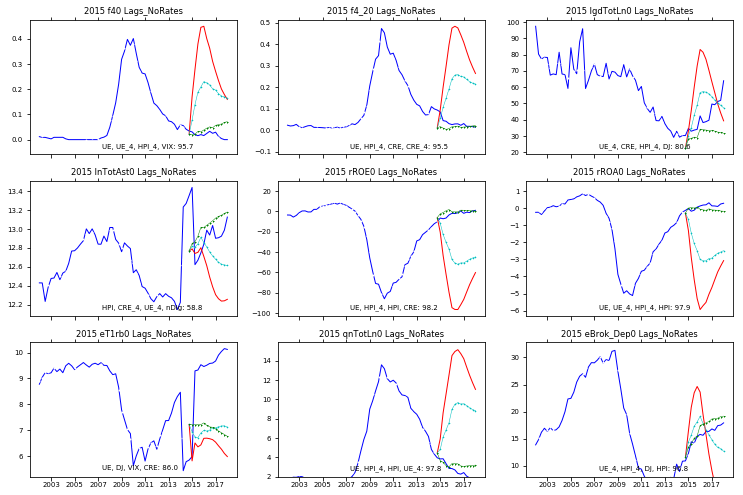

In [35]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.4, plSize[1]*1.4) )  ## double width, single height

plt.rcParams.update({'font.size': 7})
xax = list(frt4b.index)

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.5, plSize[1]*1.5) )  ## double width, single height

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')

#  if i == 6: 
#    inc = .85
#  else:
#    inc = 0

  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot'].values[0], xy=(0.35, 0.05),\
               xycoords='axes fraction', fontsize=7) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  if i == 7: plt.ylim(ymin=2)  # lnTotAst
  if i == 8: plt.ylim(ymin=8)  # lnTotAst

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) +'_4v9n_'+styp+test+'_'+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
frt4b.columns

MultiIndex(levels=[[u'eBrok_Dep0', u'eBrok_Dep1', u'eBrok_Dep2', u'eT1rb0', u'eT1rb1', u'eT1rb2', u'f40', u'f41', u'f42', u'f4_20', u'f4_21', u'f4_22', u'lgdTotLn0', u'lgdTotLn1', u'lgdTotLn2', u'lnTotAst0', u'lnTotAst1', u'lnTotAst2', u'qnTotLn0', u'qnTotLn1', u'qnTotLn2', u'rROA0', u'rROA1', u'rROA2', u'rROE0', u'rROE1', u'rROE2'], [u'Actual', u'Adverse', u'Base', u'Fit', u'SevAdv']],
           labels=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26], [0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2,

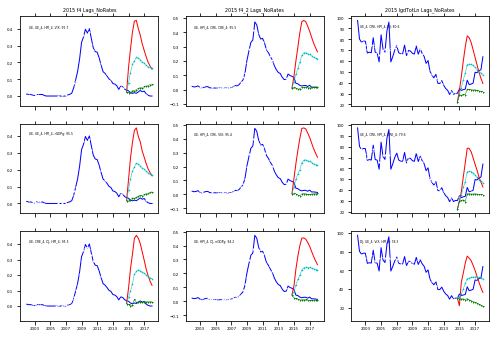

In [37]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.4, plSize[1]*1.4) )  ## double width, single height
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 4})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 4,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

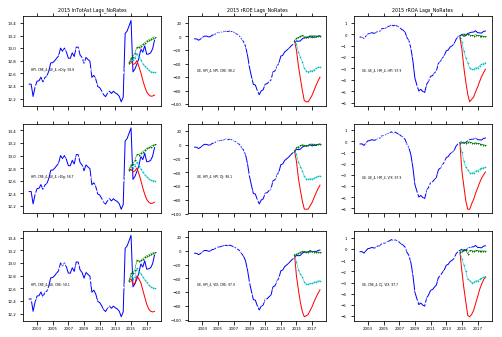

In [38]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.4, plSize[1]*1.4) )  ## double width, single height
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 4})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.4),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 4,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

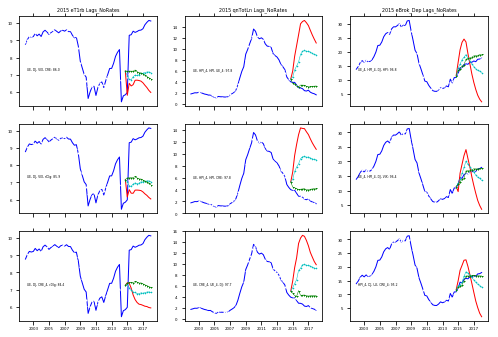

In [39]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.4, plSize[1]*1.4) )  ## double width, single height

## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 4})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.4),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 4,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [40]:
grp+'_'+str(ccar) +'_4v27'+s3d[s3]+'_'+styp+test+'.png'

'grpf4_2w4_2015_4v27c_Lags_NoRates_LossRates.png'

In [41]:
### Be careful of ver (top3 version) selection:
c4lst0=[x for x in list(frt4b.columns.levels[0]) if x[-1:]==str(ver)] ## picks one of top3 models
dz = frt4b[c4lst0]
dz.rename(columns=lambda x: x.replace(str(ver), ''), inplace=True)  ## removes ver # as suffix of col names
dz.rename(columns={'f2_':'f2_0'},inplace=True)
dz.head(2)

eBrok_Dep                                    eT1rb                 \
               Actual        Fit Base Adverse SevAdv    Actual       Fit Base   
Date                                                                            
2001-12-31  13.883590        NaN  NaN     NaN    NaN  8.776418  8.886284  NaN   
2002-03-31  14.846477  15.225869  NaN     NaN    NaN  9.044273  9.014839  NaN   

                           ...        rROA                                \
           Adverse SevAdv  ...      Actual       Fit Base Adverse SevAdv   
Date                       ...                                             
2001-12-31     NaN    NaN  ...   -0.238326       NaN  NaN     NaN    NaN   
2002-03-31     NaN    NaN  ...   -0.231892 -0.180685  NaN     NaN    NaN   

                rROE                                
              Actual       Fit Base Adverse SevAdv  
Date                                                
2001-12-31 -3.502231       NaN  NaN     NaN    NaN  
2002-03-31 -3.609016  1.311815  NaN     NaN    NaN  

[2 rows x 45 columns]

In [42]:
c4lst0

['eBrok_Dep0',
 'eT1rb0',
 'f40',
 'f4_20',
 'lgdTotLn0',
 'lnTotAst0',
 'qnTotLn0',
 'rROA0',
 'rROE0']

In [43]:
dz2=dz.swaplevel(0,1,axis=1)
dz2.sort_index(axis=1,inplace=True)
dz2.head(2)

Actual                                                      \
            eBrok_Dep     eT1rb        f4      f4_2   lgdTotLn   lnTotAst   
Date                                                                        
2001-12-31  13.883590  8.776418  0.011765  0.023346  97.359134  12.431153   
2002-03-31  14.846477  9.044273  0.008902  0.019624  80.303067  12.430436   

                                           Adverse ...        Fit    SevAdv  \
             qnTotLn      rROA      rROE eBrok_Dep ...       rROE eBrok_Dep   
Date                                               ...                        
2001-12-31  1.750444 -0.238326 -3.502231       NaN ...        NaN       NaN   
2002-03-31  1.849222 -0.231892 -3.609016       NaN ...   1.311815       NaN   

                                                               
           eT1rb  f4 f4_2 lgdTotLn lnTotAst qnTotLn rROA rROE  
Date                                                           
2001-12-31   NaN NaN  NaN      NaN      NaN     NaN  NaN  NaN  
2002-03-31   NaN NaN  NaN      NaN      NaN     NaN  NaN  NaN  

[2 rows x 45 columns]

In [44]:
##################################################################################################
##### hardcoded row index removed here:
idm = int(grp[6:7])   
#### caution:  CHECK THIS!  Model row index # here: f4_2 should result in idm=2
dc = list(prm4.ix[idm][['Int','c1','c2','c3','c4']]) 
v1 = prm4.ix[idm]['v1']
v2 = prm4.ix[idm]['v2']
v3 = prm4.ix[idm]['v3']
v4 = prm4.ix[idm]['v4']
dc, v1, v2, v3, v4

([-2.2120646047447474,
  -0.4003986919736148,
  0.11258558311426076,
  -0.029287916996022637,
  0.040636265587322216],
 'eT1rb',
 'qnTotLn',
 'rROE',
 'eBrok_Dep')

In [45]:
dz2['Fit','mod'] = dz2['Fit'].apply(lambda x:1/(1+np.exp(-np.sum(np.multiply(dc,\
                    [1.,x[v1],x[v2],x[v3],x[v4]])))),axis=1)
dz2['Adverse','mod'] = dz2['Adverse'].apply(lambda x:1/(1+np.exp(-np.sum(np.multiply(dc,\
                    [1.,x[v1],x[v2],x[v3],x[v4]])))),axis=1)
dz2['Base','mod'] = dz2['Base'].apply(lambda x:1/(1+np.exp(-np.sum(np.multiply(dc,\
                    [1.,x[v1],x[v2],x[v3],x[v4]])))),axis=1)
dz2['SevAdv','mod'] = dz2['SevAdv'].apply(lambda x:1/(1+np.exp(-np.sum(np.multiply(dc,\
                    [1.,x[v1],x[v2],x[v3],x[v4]])))),axis=1)

In [46]:
dz3=dz2.swaplevel(0,1,axis=1)
dz3.sort_index(axis=1,inplace=True)
dz3.head(2)

eBrok_Dep                                    eT1rb               \
               Actual Adverse Base        Fit SevAdv    Actual Adverse Base   
Date                                                                          
2001-12-31  13.883590     NaN  NaN        NaN    NaN  8.776418     NaN  NaN   
2002-03-31  14.846477     NaN  NaN  15.225869    NaN  9.044273     NaN  NaN   

                             ...        rROA                                \
                 Fit SevAdv  ...      Actual Adverse Base       Fit SevAdv   
Date                         ...                                             
2001-12-31  8.886284    NaN  ...   -0.238326     NaN  NaN       NaN    NaN   
2002-03-31  9.014839    NaN  ...   -0.231892     NaN  NaN -0.180685    NaN   

                rROE                                
              Actual Adverse Base       Fit SevAdv  
Date                                                
2001-12-31 -3.502231     NaN  NaN       NaN    NaN  
2002-03-31 -3.609016     NaN  NaN  1.311815    NaN  

[2 rows x 49 columns]

In [47]:
dz3['mod','defSev'] = dz3['lgdTotLn','SevAdv'] * dz3['mod','SevAdv']/100
dz3['mod','defBas'] = dz3['lgdTotLn','Base'] * dz3['mod','Base']/100
dz3['mod','defAdv'] = dz3['lgdTotLn','Adverse'] * dz3['mod','Adverse']/100
dz3['mod','defFit'] = dz3['lgdTotLn','Fit'] * dz3['mod','Fit']/100

In [48]:
'PDvar_forecast_'+grp+'_'+str(ccar)+"_"+styp+test+'_'+str(ver)+'.csv'

'PDvar_forecast_grpf4_2w4_2015_Lags_NoRates_LossRates_0.csv'

In [49]:
dz3.to_csv('PDvar_forecast_'+grp+'_'+str(ccar)+"_"+styp+test+'_'+str(ver)+'.csv')

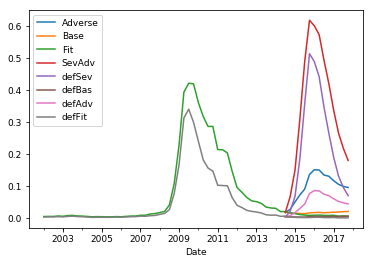

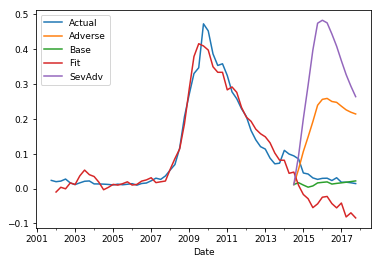

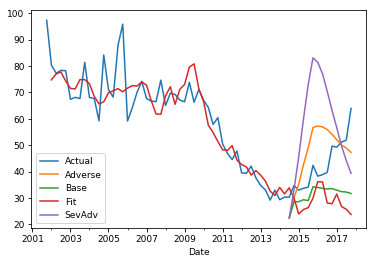

In [50]:
plt.rcParams.update({'font.size': 9})
dz3['mod'].plot()
dz3[grpm].plot()
dz3['lgdTotLn'].plot()

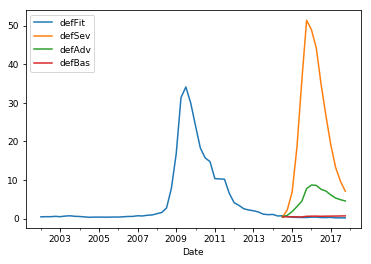

In [51]:
dz3m = dz3['mod'] * 100
dz3m[['defFit','defSev','defAdv','defBas']].plot()

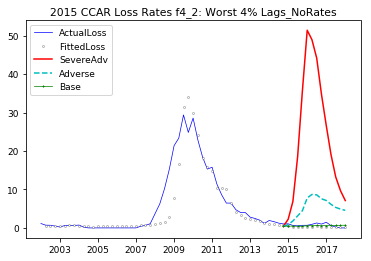

In [52]:
dzx = list(dz3.index)
dz3['mod','defAct'] = dz3[grpf,'Actual'] * dz3['lgdTotLn','Actual']/100
dz3x = dz3['mod'] * 100

plt.rcParams.update({'font.size': 9})

plt.plot(dzx,dz3x['defAct'],lw=.7,c='b',label='ActualLoss')
plt.plot(dzx,dz3x['defFit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedLoss')
plt.plot(dzx,dz3x['defSev'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3x['defAdv'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3x['defBas'],c='g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR Loss Rates '+grpm + ': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)
plt.savefig(grp+'_'+str(ccar) + '_LossRate_'+styp+test+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
grp+'_'+str(ccar) + '_LossRate_'+styp+test+'.png'

'grpf4_2w4_2015_LossRate_Lags_NoRates_LossRates.png'

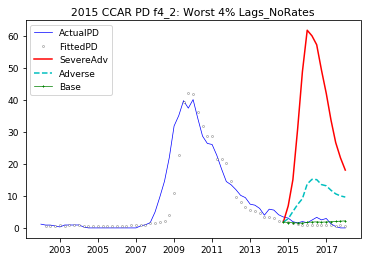

In [54]:
dz3y = dz3['mod'] * 100
dz3y['ActAct'] = dz3[grpf,'Actual'] * 100 

#plt.plot(dzx,dz3y['Actual'],c='b',lw=.7,label='ActualPD')  ## Actual from f4_2
plt.plot(dzx,dz3y['ActAct'],c='b',lw=.7,label='ActualPD')  ## Actual from f4
plt.plot(dzx,dz3y['Fit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedPD')
plt.plot(dzx,dz3y['SevAdv'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3y['Adverse'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3y['Base'],c='g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR PD '+grpm+': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)
plt.savefig(grp+'_'+str(ccar) + '_PD_'+styp+test+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
grp+'_'+str(ccar) + '_PD_'+styp+test+'.png'

'grpf4_2w4_2015_PD_Lags_NoRates_LossRates.png'

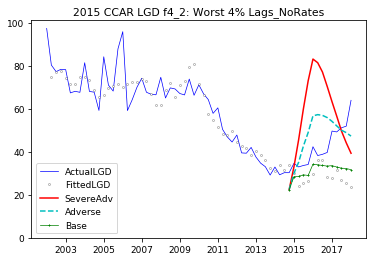

In [56]:
dz3z = dz3['lgdTotLn'] 

plt.plot(dzx,dz3z['Actual'],lw=.7,c='b',label='ActualLGD')
plt.plot(dzx,dz3z['Fit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedLGD')
plt.plot(dzx,dz3z['SevAdv'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3z['Adverse'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3z['Base'],'g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR LGD '+grpm+': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)
plt.ylim(ymin=0)
plt.savefig(grp+'_'+str(ccar) + '_LGD_'+styp+test+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
grp+'_'+str(ccar) + '_LGD_'+styp+test+'.png'

'grpf4_2w4_2015_LGD_Lags_NoRates_LossRates.png'

In [58]:
grp+'_'+str(ccar) + '_forecasts_'+styp+test+'.csv'

'grpf4_2w4_2015_forecasts_Lags_NoRates_LossRates.csv'

In [59]:
dz3.to_csv(grp+'_'+str(ccar) + '_forecasts_'+styp+test+'.csv')

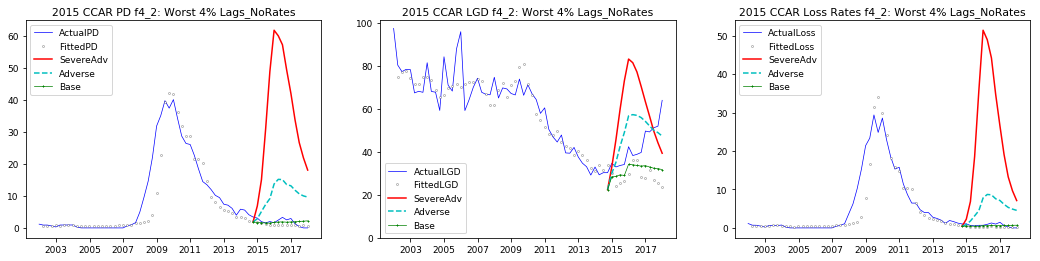

In [60]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

dzx = list(dz3.index)

plt.subplot(1, 3, 1)
dz3y = dz3['mod'] * 100
dz3y['ActAct'] = dz3[grpf,'Actual'] * 100 

plt.plot(dzx,dz3y['ActAct'],c='b',lw=.7,label='ActualPD')  ## Actual from f4
plt.plot(dzx,dz3y['Fit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedPD')
plt.plot(dzx,dz3y['SevAdv'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3y['Adverse'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3y['Base'],c='g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR PD '+grpm+': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)

plt.subplot(1, 3, 2)
dz3z = dz3['lgdTotLn'] 

plt.plot(dzx,dz3z['Actual'],'b',lw=.7,label='ActualLGD')
plt.plot(dzx,dz3z['Fit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedLGD')
plt.plot(dzx,dz3z['SevAdv'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3z['Adverse'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3z['Base'],c='g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR LGD '+grpm+': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)
plt.ylim(ymin=0)

plt.subplot(1,3,3)
dz3['mod','defAct'] = dz3[grpf,'Actual'] * dz3['lgdTotLn','Actual']/100
dz3x = dz3['mod'] * 100

plt.rcParams.update({'font.size': 9})

plt.plot(dzx,dz3x['defAct'],'b',lw=.7,label='ActualLoss')
plt.plot(dzx,dz3x['defFit'],ls='',c='k',marker='.',ms=4,mew=.25,mfc='w',label='FittedLoss')
plt.plot(dzx,dz3x['defSev'],'r-',lw=1.5,label='SevereAdv')
plt.plot(dzx,dz3x['defAdv'],'c--',lw=1.5,label='Adverse')
plt.plot(dzx,dz3x['defBas'],c='g',lw=.7,marker='+',ms=2,label='Base')
plt.title('2015 CCAR Loss Rates '+grpm + ': Worst '+str(wpc)+'% '+styp)
plt.legend(loc=0)

plt.savefig(grp+'_'+str(ccar) + '_PDLGDLossRt_'+styp+test+'.png', dpi=400, bbox_inches='tight')
plt.show()